In [15]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Step 1: Create and Save Risk-Free Rate File
# Load Treasury Yield data
file_path = "../data/DGS3MO.csv"  # Update this path to your actual file location
try:
    df_treasuryyield = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"File not found: {file_path}. Ensure the file exists.")
    exit()

# Preprocess Treasury Yield data
df_treasuryyield['observation_date'] = pd.to_datetime(df_treasuryyield['observation_date'])
df_treasuryyield['DGS3MO'] = df_treasuryyield['DGS3MO'].interpolate(method='cubic')  # Interpolate missing values
df_treasuryyield['DGS3MO'] = (1 + df_treasuryyield['DGS3MO'] / 100)**(1 / 252) - 1  # Convert annual yield to daily yield
df_treasuryyield.rename(columns={'observation_date': 'Date', 'DGS3MO': 'Risk_Free_Rate'}, inplace=True)

# Save the new risk-free rate data to a CSV file
risk_free_file = "risk_free_rate.csv"
df_treasuryyield.to_csv(risk_free_file, index=False)
print(f"Risk-free rate file saved as: {risk_free_file}")

Risk-free rate file saved as: risk_free_rate.csv


# OLS3 Portfolio Strategy

/var/folders/q_/ky0ymwwd27v0lpzm4dgf3kxr0000gn/T/ipykernel_62070/2021826134.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_year.loc[:, 'predicted_risk_premium'] = predictions_year
/var/folders/q_/ky0ymwwd27v0lpzm4dgf3kxr0000gn/T/ipykernel_62070/2021826134.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_year.loc[:, 'predicted_risk_premium'] = predictions_year
/var/folders/q_/ky0ymwwd27v0lpzm4dgf3kxr0000gn/T/ipykernel_62070/2021826134.py:73: SettingWithCopyWarning: 
A value is t

Sharpe Ratio: 2.9173610149884164
Final Cumulative Return: 0.2326269697329182
Overall R^2: 0.04428371750842364


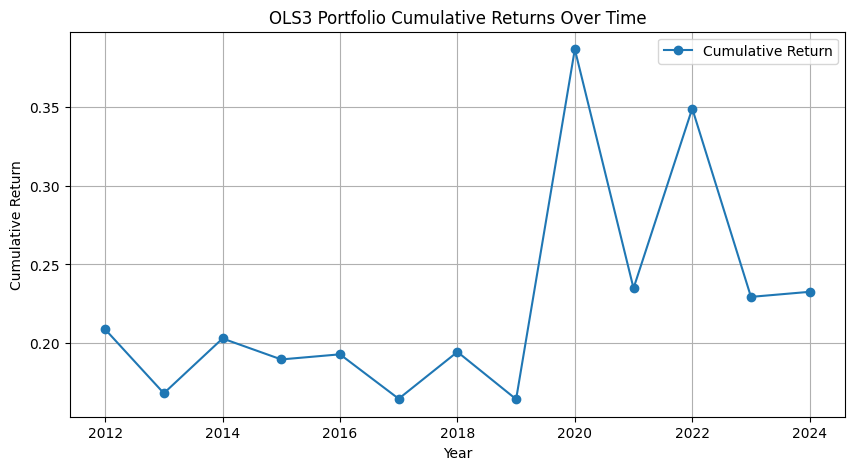

In [31]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Step 1: Load Equity Data and Merge with Risk-Free Rate Data
file_path = "../data/cleaned_df_with_tickers.csv"
df_equity = pd.read_csv(file_path)
df_equity['Date'] = pd.to_datetime(df_equity['Date'])

risk_free_file = "risk_free_rate.csv"
df_risk_free = pd.read_csv(risk_free_file)
df_risk_free['Date'] = pd.to_datetime(df_risk_free['Date'])

# Merge equity data with Risk-Free Rate data on Date
df = pd.merge(df_equity, df_risk_free, on='Date', how='left')

# Step 2: Portfolio Allocation and Performance Metrics

# Define features and target variable
features = ['mvel1', 'bm', 'mom1m']  # Exclude 'Ticker' from features
target = 'risk_premium'

# Initialize scaler
scaler = StandardScaler()

# Initialize portfolio performance tracking
portfolio_returns = []

# Initialize lists to store actual and predicted values for overall R^2 calculation and DM test purposes
y_actual_all = []
y_pred_all = []

start_year = 2012  # Start from the first test year
end_year = 2024

# Step 3: Compute Daily Predictions (Once)
daily_predictions_df = []  # Store daily predictions for reuse

for year in range(start_year, end_year + 1):
    train_start_year = year - 11
    train_end_year = year - 1

    # Define training and testing data for the year
    train_data = df[(df['Date'] >= f'{train_start_year}-01-01') & (df['Date'] <= f'{train_end_year}-12-31')]
    test_data_year = df[(df['Date'] >= f'{year}-01-01') & (df['Date'] <= f'{year}-12-31')]

    # Prepare training sets
    X_train = train_data[features]
    y_train = train_data[target]

    # Standardize features for training data
    X_train = scaler.fit_transform(X_train)
    X_train = sm.add_constant(X_train)

    # Fit OLS model using training data
    model = sm.OLS(y_train, X_train).fit()

    # Prepare testing sets for the year
    X_test_year = test_data_year[features]
    y_test_year = test_data_year[target]

    # Standardize features for testing data
    X_test_year = scaler.transform(X_test_year)
    X_test_year = sm.add_constant(X_test_year)

    # Make predictions for the year (Daily Predictions)
    predictions_year = model.predict(X_test_year)

    # Store daily predictions in a DataFrame for reuse during monthly rebalancing
    test_data_year.loc[:, 'predicted_risk_premium'] = predictions_year

    daily_predictions_df.append(test_data_year)

    # Collect actual and predicted values for overall R^2 calculation and DM test purposes
    y_actual_all.extend(y_test_year)
    y_pred_all.extend(predictions_year)

# Combine all daily predictions into a single DataFrame
daily_predictions_df = pd.concat(daily_predictions_df)

# Step 4: Monthly Rebalancing Using Daily Predictions
for year in range(start_year, end_year + 1):
    test_data_year = daily_predictions_df[daily_predictions_df['Date'].dt.year == year]

    monthly_returns = []
    
    for month in range(1, 13):
        # Filter test data for the current month
        test_data_month = test_data_year[test_data_year['Date'].dt.month == month]
        
        if test_data_month.empty:
            continue
        
        # Group by Ticker and calculate deciles within each group using predicted risk premiums
        def safe_qcut(x):
            if len(x.unique()) == 1:
                return pd.Series([0] * len(x), index=x.index)  # Assign all to one bin if values are identical
            else:
                return pd.qcut(x.rank(method='first'), q=10, labels=False)
        
        test_data_month['decile'] = (
            test_data_month.groupby('Ticker')['predicted_risk_premium']
            .transform(safe_qcut)
        )
        
        # Calculate long-short returns based on top and bottom deciles
        # Using risk_premium instead of actual_return
        top_decile_returns = test_data_month[test_data_month['decile'] == 9]['risk_premium'].mean()
        bottom_decile_returns = test_data_month[test_data_month['decile'] == 0]['risk_premium'].mean()
        
        long_short_return_month = top_decile_returns - bottom_decile_returns
        
        # Calculate average daily risk-free rate for the current month from treasury yield data
        avg_risk_free_rate_month = test_data_month['Risk_Free_Rate'].mean()
        
        # Since risk_premium is already excess return (return - risk-free rate),
        # the excess return of the long-short portfolio is just the long-short return
        monthly_returns.append({
            'Month': month,
            'Long-Short Return': long_short_return_month,
            'Risk-Free Rate': avg_risk_free_rate_month,
            'Excess Return': long_short_return_month,  # Already excess return
        })
    
    if monthly_returns:
        monthly_df = pd.DataFrame(monthly_returns)
        
        yearly_cumulative_return = (1 + monthly_df['Long-Short Return']).prod() - 1
        
        portfolio_returns.append({
            'Year': year,
            'Yearly Cumulative Return': yearly_cumulative_return,
            'Sharpe Ratio': monthly_df['Excess Return'].mean() / monthly_df['Excess Return'].std() if monthly_df['Excess Return'].std() != 0 else 0,
        })

# Convert portfolio performance to DataFrame for analysis
portfolio_df = pd.DataFrame(portfolio_returns)

# Calculate overall R^2 for all years in the test set using collected actual and predicted values
overall_r2 = r2_score(y_actual_all, y_pred_all)

# Save updated DataFrame with Sharpe ratio and cumulative return columns to CSV file for further analysis
portfolio_df.to_csv('OLS3_portfolio_performance.csv', index=False)

# Save actual and predicted values to a CSV file for DM test purposes
dm_test_df = pd.DataFrame({
    'y_actual': y_actual_all,
    'y_pred': y_pred_all
})
dm_test_df.to_csv('dm_test_OLS3_results.csv', index=False)

# Print Sharpe Ratio, Final Cumulative Return, and Overall R^2 for verification
print("Sharpe Ratio:", portfolio_df['Sharpe Ratio'].mean())
print("Final Cumulative Return:", portfolio_df['Yearly Cumulative Return'].iloc[-1])
print("Overall R^2:", overall_r2)

# Plot cumulative returns over time starting from 2012
plt.figure(figsize=(10, 5))
plt.plot(portfolio_df['Year'], portfolio_df['Yearly Cumulative Return'], marker='o', label='Cumulative Return')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.title('OLS3 Portfolio Cumulative Returns Over Time')
plt.legend()
plt.grid()
plt.show()

# OLS

/var/folders/q_/ky0ymwwd27v0lpzm4dgf3kxr0000gn/T/ipykernel_62070/2083534522.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_year.loc[:, 'predicted_risk_premium'] = predictions_year
/var/folders/q_/ky0ymwwd27v0lpzm4dgf3kxr0000gn/T/ipykernel_62070/2083534522.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_year.loc[:, 'predicted_risk_premium'] = predictions_year
/var/folders/q_/ky0ymwwd27v0lpzm4dgf3kxr0000gn/T/ipykernel_62070/2083534522.py:68: SettingWithCopyWarning: 
A value is t

Sharpe Ratio: 2.985349773537279
Final Cumulative Return: 0.24156153618873177
Overall R^2: -1.3562354130043928


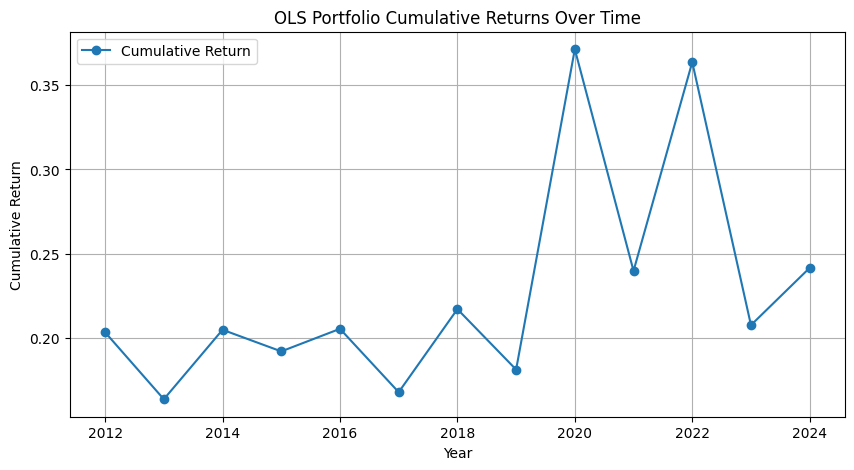

In [34]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Step 1: Load Equity Data and Merge with Risk-Free Rate Data
file_path = "../data/cleaned_df_with_tickers.csv"
df_equity = pd.read_csv(file_path)
df_equity['Date'] = pd.to_datetime(df_equity['Date'])

risk_free_file = "risk_free_rate.csv"
df_risk_free = pd.read_csv(risk_free_file)
df_risk_free['Date'] = pd.to_datetime(df_risk_free['Date'])

df = pd.merge(df_equity, df_risk_free, on='Date', how='left')

# Step 2: Define features and target variable
# Exclude 'Ticker', 'Date', 'risk_premium', and 'Risk_Free_Rate' from predictors
exclude_cols = ['Ticker', 'Date', 'risk_premium', 'Risk_Free_Rate']
features = [col for col in df.columns if col not in exclude_cols]
target = 'risk_premium'

# Initialize scaler (we re-fit the scaler each year)
scaler = StandardScaler()

# Initialize portfolio performance tracking and lists to store predictions
portfolio_returns = []
y_actual_all = []
y_pred_all = []

start_year = 2012  # Start from the first test year
end_year = 2024

daily_predictions_df = []  # Store daily predictions for reuse

for year in range(start_year, end_year + 1):
    train_start_year = year - 11
    train_end_year = year - 1

    # Define training and testing data for the year
    train_data = df[(df['Date'] >= f'{train_start_year}-01-01') & (df['Date'] <= f'{train_end_year}-12-31')]
    test_data_year = df[(df['Date'] >= f'{year}-01-01') & (df['Date'] <= f'{year}-12-31')]

    # Prepare training sets
    X_train = train_data[features]
    y_train = train_data[target]

    # Standardize features for training data and add constant explicitly
    X_train_scaled = scaler.fit_transform(X_train)
    X_train_scaled = sm.add_constant(X_train_scaled, has_constant='add')

    # Fit OLS model using training data
    model = sm.OLS(y_train, X_train_scaled).fit()

    # Prepare testing sets for the year using the same scaler and ensuring constant addition
    X_test_year = test_data_year[features]
    y_test_year = test_data_year[target]

    X_test_year_scaled = scaler.transform(X_test_year)
    X_test_year_scaled = sm.add_constant(X_test_year_scaled, has_constant='add')

    # Make predictions (Daily Predictions)
    predictions_year = model.predict(X_test_year_scaled)

    # Store daily predictions in a DataFrame for reuse during monthly rebalancing
    test_data_year.loc[:, 'predicted_risk_premium'] = predictions_year
    daily_predictions_df.append(test_data_year)

    # Collect actual and predicted values for overall R^2 calculation and further tests
    y_actual_all.extend(y_test_year)
    y_pred_all.extend(predictions_year)

# Combine all daily predictions into a single DataFrame
daily_predictions_df = pd.concat(daily_predictions_df)

# Step 4: Monthly Rebalancing Using Daily Predictions
for year in range(start_year, end_year + 1):
    test_data_year = daily_predictions_df[daily_predictions_df['Date'].dt.year == year]
    monthly_returns = []
    
    for month in range(1, 13):
        # Filter data for the month
        test_data_month = test_data_year[test_data_year['Date'].dt.month == month]
        if test_data_month.empty:
            continue
        
        # Group by Ticker and calculate deciles based on predicted risk premium
        def safe_qcut(x):
            if len(x.unique()) == 1:
                return pd.Series([0] * len(x), index=x.index)
            else:
                return pd.qcut(x.rank(method='first'), q=10, labels=False)
        
        test_data_month['decile'] = (
            test_data_month.groupby('Ticker')['predicted_risk_premium']
            .transform(safe_qcut)
        )
        
        # Long–short returns: long the top decile and short the bottom decile using risk_premium (which is excess return)
        top_decile_returns = test_data_month[test_data_month['decile'] == 9]['risk_premium'].mean()
        bottom_decile_returns = test_data_month[test_data_month['decile'] == 0]['risk_premium'].mean()
        long_short_return_month = top_decile_returns - bottom_decile_returns
        
        # Average daily risk-free rate for the month used for informational purposes
        avg_risk_free_rate_month = test_data_month['Risk_Free_Rate'].mean()
        
        monthly_returns.append({
            'Month': month,
            'Long-Short Return': long_short_return_month,
            'Risk-Free Rate': avg_risk_free_rate_month,
            'Excess Return': long_short_return_month  # Already excess return
        })
    
    if monthly_returns:
        monthly_df = pd.DataFrame(monthly_returns)
        yearly_cumulative_return = (1 + monthly_df['Long-Short Return']).prod() - 1
        sharpe = (monthly_df['Excess Return'].mean() / monthly_df['Excess Return'].std()
                  if monthly_df['Excess Return'].std() != 0 else 0)
        portfolio_returns.append({
            'Year': year,
            'Yearly Cumulative Return': yearly_cumulative_return,
            'Sharpe Ratio': sharpe,
        })

# Convert portfolio performance to DataFrame for analysis
portfolio_df = pd.DataFrame(portfolio_returns)

# Calculate overall R^2 using collected actual and predicted values
overall_r2 = r2_score(y_actual_all, y_pred_all)

# Save performance results and prediction outcomes to CSV files
portfolio_df.to_csv('OLS_portfolio_performance.csv', index=False)
dm_test_df = pd.DataFrame({'y_actual': y_actual_all, 'y_pred': y_pred_all})
dm_test_df.to_csv('dm_test_OLS_results.csv', index=False)

# Print key performance metrics
print("Sharpe Ratio:", portfolio_df['Sharpe Ratio'].mean())
print("Final Cumulative Return:", portfolio_df['Yearly Cumulative Return'].iloc[-1])
print("Overall R^2:", overall_r2)

# Plot cumulative returns over time starting from 2012
plt.figure(figsize=(10, 5))
plt.plot(portfolio_df['Year'], portfolio_df['Yearly Cumulative Return'], marker='o', label='Cumulative Return')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.title('OLS Portfolio Cumulative Returns Over Time')
plt.legend()
plt.grid()
plt.show()